In [1]:
import time
import numpy as np

import mss
import cv2
from PIL import Image

import matplotlib.pyplot as plt

from xpc3 import *
from xpc3_helper_sm import *

In [63]:
left_edge_1 = [35929.9796875, -190.48041382, 46803.98203125]
left_edge_2 = [35753.2046875, -185.55480957, 46404.71953125]
right_edge_1 = [35950.821875, -190.52763977, 46794.65]
right_edge_2 = [35773.7703125, -185.58735657, 46395.5515625]

In [35]:
def get_image_coord(client, pt, sh, sw):
    mv = np.reshape(client.getDREF("sim/graphics/view/world_matrix"), (4, 4)).T
    proj = np.reshape(client.getDREF(
        "sim/graphics/view/projection_matrix_3d"), (4, 4)).T

    pt_h = np.append(np.array(pt), 1.0)
    pt_eye = mv @ pt_h
    pt_ndc = proj @ pt_eye
    pt_ndc = pt_ndc[:3] / pt_ndc[3]
    xp = sw * (pt_ndc[0] * 0.5 + 0.5)
    yp = sh - sh * (pt_ndc[1] * 0.5 + 0.5)
    return xp, yp

In [23]:
def get_pixels(line, sw):
    a, b, c = line
    xs = np.arange(0, sw, 1)
    ys = [-(a / b) * x + (-c / b) for x in xs]
    return xs, ys

In [10]:
client = XPlaneConnect()
reset(client, dtpInit=270.0)

In [11]:
def get_local_coord(client):
    x = client.getDREF("sim/flightmodel/position/local_x")[0]
    y = client.getDREF("sim/flightmodel/position/local_y")[0]
    z = client.getDREF("sim/flightmodel/position/local_z")[0]
    return np.array([x, y, z, 1.0])

In [15]:
lc = get_local_coord(client)
mv = np.reshape(client.getDREF("sim/graphics/view/world_matrix"), (4, 4)).T
mv @ lc

array([ 0.35105041, -0.75895691,  1.15482447,  1.        ])

# Try everything with Plucker matrices

In [25]:
setHomeState(client, 0, 250, 0)
time.sleep(0.2)
screen_shot = mss.mss()
ss = cv2.cvtColor(np.array(screen_shot.grab(
    screen_shot.monitors[2])), cv2.COLOR_BGRA2BGR)[:, :, ::-1]
sh, sw, _ = ss.shape

In [64]:
Aright = np.append(np.array(right_edge_1), 1.0)
Bright = np.append(np.array(right_edge_2), 1.0)
Lright = np.outer(Aright, Bright) - np.outer(Bright, Aright)

In [65]:
Lright

array([[ 0.00000000e+00,  1.43874025e+05, -6.06285094e+06,
         1.77051563e+02],
       [-1.43874025e+05,  0.00000000e+00, -1.55139540e+05,
        -4.94028320e+00],
       [ 6.06285094e+06,  1.55139540e+05,  0.00000000e+00,
         3.99098438e+02],
       [-1.77051563e+02,  4.94028320e+00, -3.99098438e+02,
         0.00000000e+00]])

In [72]:
mv = np.reshape(client.getDREF("sim/graphics/view/world_matrix"), (4, 4)).T
proj = np.reshape(client.getDREF("sim/graphics/view/projection_matrix_3d"), (4, 4)).T
proj_3 = np.zeros((3, 4))
proj_3[:2, :] = proj[:2, :]
proj_3[2, :] = proj[3, :]

screen_mat = np.array([[0.5 * sw, 0.0, 0.5 * sw],
                       [0.0, -0.5 * sh, 0.5 * sh],
                       [0.0, 0.0, 1.0]])

P = screen_mat @ proj_3 @ mv

In [73]:
lx = P @ Lright @ P.T
line_right = np.array([lx[2, 1], lx[0, 2], lx[1, 0]])

In [74]:
lx

array([[ 1.86124585e-03,  4.25776409e+09,  5.39967040e+06],
       [-4.25776409e+09, -5.82592285e-04, -1.32568979e+06],
       [-5.39967040e+06,  1.32568979e+06,  3.08591375e-10]])

In [78]:
P.T @ line_right

array([-1.41471709e+09, -6.17767293e+09,  5.51138259e+08,  2.38929028e+13])

In [75]:
x1, y1 = get_image_coord(client, right_edge_1, sh, sw)
x2, y2 = get_image_coord(client, right_edge_2, sh, sw)
line1 = np.cross(np.array([x1, y1, 1]), np.array([x2, y2, 1]))

(-0.5, 1919.5, 1079.5, -0.5)

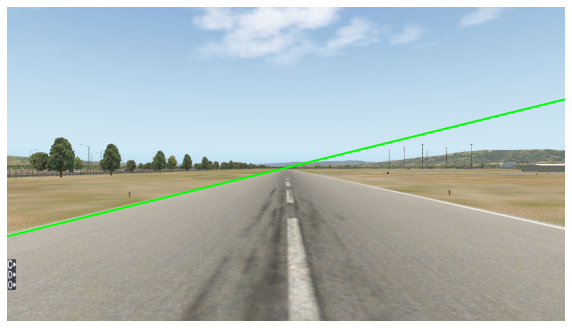

In [77]:
plt.figure(figsize=(10, 6))
plt.imshow(ss)
xs, ys = get_pixels(line_right, sw)
xs1, ys1 = get_pixels(line1, sw)
plt.plot(xs, ys, c='lime', linewidth=2.0)
# plt.plot(xs1, ys1, c='red', linewidth=2.0)
plt.axis('off')


# Line Fundamental Matrix

In [85]:
Aright = np.append(np.array(right_edge_1), 1.0)
Bright = np.append(np.array(right_edge_2), 1.0)
Lright = np.outer(Aright, Bright) - np.outer(Bright, Aright)

### Get line when in center

In [254]:
setHomeState(client, 0, 250, 0)
time.sleep(0.2)
screen_shot = mss.mss()
ss = cv2.cvtColor(np.array(screen_shot.grab(
    screen_shot.monitors[2])), cv2.COLOR_BGRA2BGR)[:, :, ::-1]
sh, sw, _ = ss.shape

In [255]:
mv0 = np.reshape(client.getDREF("sim/graphics/view/world_matrix"), (4, 4)).T
proj0 = np.reshape(client.getDREF(
    "sim/graphics/view/projection_matrix_3d"), (4, 4)).T
proj_30 = np.zeros((3, 4))
proj_30[:2, :] = proj0[:2, :]
proj_30[2, :] = proj0[3, :]

screen_mat0 = np.array([[0.5 * sw, 0.0, 0.5 * sw],
                       [0.0, -0.5 * sh, 0.5 * sh],
                       [0.0, 0.0, 1.0]])

P0 = screen_mat0 @ proj_30 @ mv0
lx = P0 @ Lright @ P0.T
l0 = np.array([lx[2, 1], lx[0, 2], lx[1, 0]])

### Move over 5 m

In [256]:
setHomeState(client, 5, 250, 0)
time.sleep(0.2)
screen_shot = mss.mss()
ss = cv2.cvtColor(np.array(screen_shot.grab(
    screen_shot.monitors[2])), cv2.COLOR_BGRA2BGR)[:, :, ::-1]
sh, sw, _ = ss.shape

In [257]:
mv1 = np.reshape(client.getDREF(
    "sim/graphics/view/world_matrix"), (4, 4)).T
proj1 = np.reshape(client.getDREF(
    "sim/graphics/view/projection_matrix_3d"), (4, 4)).T
proj_31 = np.zeros((3, 4))
proj_31[:2, :] = proj1[:2, :]
proj_31[2, :] = proj1[3, :]

screen_mat1 = np.array([[0.5 * sw, 0.0, 0.5 * sw],
                              [0.0, -0.5 * sh, 0.5 * sh],
                              [0.0, 0.0, 1.0]])

P = screen_mat1 @ proj_31 @ mv1
lx = P @ Lright @ P.T
l1 = np.array([lx[2, 1], lx[0, 2], lx[1, 0]])

In [258]:
l0 = l0 / l0[2]
l1 = l1 / l1[2]

In [259]:
K0 = screen_mat0 @ proj_30
K1 = screen_mat1 @ proj_31

In [260]:
lc0 = K0[:3, :3].T @ l0
lc1 = K1[:3, :3].T @ l1

In [261]:
lc0 = lc0 / lc0[2]
lc1 = lc1 / lc1[2]

In [262]:
l0, l1

(array([-3.11358206e-04, -1.26819389e-03,  1.00000000e+00]),
 array([-4.56888139e-04, -1.01565447e-03,  1.00000000e+00]))

In [263]:
lc0, lc1

(array([ 21.89235617, -89.16979947,   1.        ]),
 array([ 40.41434882, -89.8403996 ,   1.        ]))

In [232]:
x1, y1 = get_image_coord(client, right_edge_1, sh, sw)

In [233]:
p = np.array([x1, y1, 1.0])

In [234]:
pc = np.linalg.inv(K1[:3, :3]) @ p

In [235]:
K1[:3, :3] @ pc

array([948.42469705, 557.94172404,   1.        ])

In [236]:
np.dot(p, l1)

-0.0005960464477539062

In [237]:
np.dot(pc, lc1)

-0.0005957260727882385

In [238]:
Tx = np.array([[0.0, 0.0, 0.0],
               [0.0, 0.0, 5.0],
               [0.0, -5.0, 0.0]])

In [239]:
Tx @ np.eye(3)

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  5.],
       [ 0., -5.,  0.]])

In [240]:
lc1.T @ Tx.T @ lc0

8586385860346615.0

In [204]:
def get_sim(translation):
    Tx = np.array([[0.0, 0.0, 0.0],
                   [0.0, 0.0, -translation],
                   [0.0, translation, 0.0]])
    return lc1.T @ Tx.T @ lc0

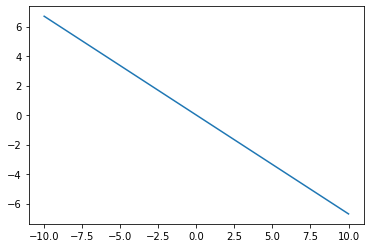

In [205]:
ts = np.linspace(-10, 10, 100)
vals = np.array([get_sim(t) for t in ts])
plt.plot(ts, vals)

In [274]:
# Check if ps translate
p0 = P0 @ np.append(np.array(right_edge_1), 1)
p0 = p0 / p0[2]

p1 = P @ np.append(np.array(right_edge_1), 1)
p1 = p1 / p1[2]

In [275]:
p0, p1

(array([938.86965637, 558.01816644,   1.        ]),
 array([948.42469705, 557.94172404,   1.        ]))

In [277]:
np.dot(p0, l0)

9.653389199115736e-13

In [270]:
# Check if ps translate
p0 = P0 @ np.append(np.array(right_edge_2), 1)
p0 = p0 / p0[2]

p1 = P @ np.append(np.array(right_edge_2), 1)
p1 = p1 / p1[2]

In [271]:
p0, p1

(array([883.16888213, 571.69343591,   1.        ]),
 array([918.48291524, 571.41091596,   1.        ]))

In [273]:
np.dot(p1, l1)

4.2676973066591017e-13

In [269]:
# Check if ps translate
p0 = mv0 @ np.append(np.array(right_edge_1), 1)
p0 = p0 / p0[2]

p1 = mv1 @ np.append(np.array(right_edge_1), 1)
p1 = p1 / p1[2]
p0, p1

(array([ 0.01846923,  0.015749  ,  1.        , -0.00167067]),
 array([ 0.01011753,  0.01568218,  1.        , -0.00167067]))

In [267]:
np.dot(p0, lc0)

-19.813540343231693

In [268]:
np.dot(p1, lc1)

-36.777796993170526

In [278]:
l0, l1

(array([-3.11358206e-04, -1.26819389e-03,  1.00000000e+00]),
 array([-4.56888139e-04, -1.01565447e-03,  1.00000000e+00]))

In [279]:
l0 * (l1[0] / l0[0])

array([-4.56888139e-04, -1.86095222e-03,  1.46740356e+00])

In [280]:
1.46740356e+00 / -4.56888139e-04

-3211.7348531124812

In [283]:
P0.T @ l0

array([ 3.32267609e-01,  1.45091950e+00, -1.29443118e-01, -5.61160795e+03])

# Try Intersection of Planes Approach

### Compute the Ground Plane

In [284]:
def get_plane(A, B, C):
    v1 = A - B
    v2 = C - A
    n = np.cross(v1, v2)
    k = -np.dot(A, n)
    return np.array([n[0], n[1], n[2], k])

In [287]:
ground_plane = get_plane(np.array(right_edge_1), np.array(right_edge_2), np.array(left_edge_1))
ground_plane

array([-6.49506801e+01, -9.97033518e+03, -9.46048805e+01,  4.86240817e+06])

In [288]:
def get_plane_int(p1, p2):
    p1_normal = p1[:3] 
    p2_normal = p2[:3]
    
    p3_normal = np.cross(p1_normal, p2_normal)
    det = np.sum(np.square(p3_normal))

    r_point = (np.cross(p3_normal, p2_normal) * p1[3] + np.cross(p1_normal, p3_normal) * p2[3]) / det
    r_normal = p3_normal

    return r_point, r_normal

In [289]:
edge_plane = P0.T @ l0

In [292]:
edge_point, edge_vec = get_plane_int(edge_plane, ground_plane)
edge_point, edge_vec

(array([12695.35569286,   458.37139996, -5626.35146216]),
 array([-1427.85533645,    39.84155594, -3218.58121843]))

In [294]:
(right_edge_1[0] - edge_point[0]) / edge_vec[0]

-16.286990417368994

In [295]:
(right_edge_1[1] - edge_point[1]) / edge_vec[1]

-16.286990417368052

In [296]:
(right_edge_1[2] - edge_point[2]) / edge_vec[2]

-16.286990417367768

(-0.5, 1919.5, 1079.5, -0.5)

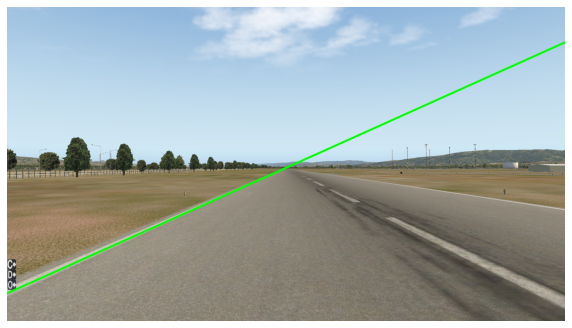

In [131]:
plt.figure(figsize=(10, 6))
plt.imshow(ss)
xs, ys = get_pixels(l1, sw)
plt.plot(xs, ys, c='lime', linewidth=2.0)
# plt.plot(xs1, ys1, c='red', linewidth=2.0)
plt.axis('off')